<a href="https://colab.research.google.com/github/gourav10/autoencoder_embedding/blob/main/triplet_loss_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Imports and Model definations

In [1]:
from google.colab import drive
import os

In [2]:
import pandas as pd
import numpy as np
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


## Data Prep. for Encoder Training using Triplet Loss

In [6]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_test.csv')

In [7]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [8]:
train_df.head()

5  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.608  0.609  0.610  \
0  0  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  1  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  2  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.611  0.612  0.613  0.614  0.615  0.616  0.617  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

In [9]:
train_df.rename(columns={'5':'label'},inplace=True)

In [10]:
test_df.rename(columns={'7':'label'},inplace=True)

In [11]:
test_df.head()

label  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.658  0.659  0.660  \
0      2  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1      1  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2      0  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3      4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4      1  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.661  0.662  0.663  0.664  0.665  0.666  0.667  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

## Define Triplet Dataset

In [12]:
class Triplet_MNIST(Dataset):
    def __init__(self, df, is_train=True,transform = None):
        self.is_train = is_train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:
            self.images = df.iloc[:,1:].values.astype(np.uint8)
            self.labels = df.iloc[:,0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        anchor_img = self.images[index].reshape(28,28,1)
        
        if self.is_train:
            anchor_label = self.labels[index]
            
            positive_list = self.index[self.index!=index][self.labels[self.index!=index]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28,28,1)
            
            negative_list = self.index[self.index!=index][self.labels[self.index!=index]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [13]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

In [14]:
batch_size = 32
epochs = 50

In [15]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
from torchvision import datasets

# Define Model

In [16]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,
                 fc2_input_dim,
                 in_channels=1) -> None:
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            # 1st convolutional layer
            nn.Conv2d(in_channels, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # 2nd Convolutional Layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 3rd Convolutional Layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_linear = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, out_channels=1) -> None:
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the
        # output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


## Helper Methods

In [17]:
def generate_embeddings(encoder, test_data, device):
  encoded_samples = []
  for sample in tqdm(test_data):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      encoder.eval()
      with torch.no_grad():
          encoded_img  = encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  return encoded_samples

In [18]:
def visualize_embeddings_2D(x_values, y_values, labels, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(experiment_name)
    plt.show()

In [19]:
def save_model(model, model_name=''):
    os.makedirs('temp', exist_ok=True)
    dest_path_encoder = os.path.join('temp', f'{model_name}.pt')
    torch.jit.save(model, dest_path_encoder)

In [20]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

In [21]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
    return km

In [22]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

In [43]:
def visualize_embeddings_2D(x_values, y_values, labels, name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(name)
    plt.show()


def cluster_latent_space(clustering_model, embedding_df, name = ""):
    clustering_results = clustering_model.fit_transform(
        embedding_df.drop(["label"], axis=1)
    )
    visualize_embeddings_2D(
        clustering_results[:, 0], clustering_results[:, 1], embedding_df.label, name
    )

## Training and Validation

In [23]:
def __train( encoder, decoder, train_loader, criterion_encoder, criterion_decoder, optimizer):
  encoder.train()
  decoder.train()
  train_loss = []
  for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
      anchor_img = anchor_img.to(device)
      positive_img = positive_img.to(device)
      negative_img = negative_img.to(device)
      
      optimizer.zero_grad()
      anchor_out = encoder(anchor_img)
      positive_out = encoder(positive_img)
      negative_out = encoder(negative_img)
      
      decoded_data = decoder(anchor_out)
      loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

      loss_decoder = criterion_decoder(decoded_data, anchor_img)
      
      loss = loss_encoder+loss_decoder
      loss.backward()

      optimizer.step()
      

      train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)


In [24]:
def __validate( encoder, decoder, val_loader, criterion_encoder, criterion_decoder, optimizer):
  encoder.eval()
  decoder.eval()
  val_loss = []
  with torch.no_grad():
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_loader, desc="Validating", leave=False)):
      anchor_img = anchor_img.to(device)
      positive_img = positive_img.to(device)
      negative_img = negative_img.to(device)
      
      # optimizer.zero_grad()
      anchor_out = encoder(anchor_img)
      positive_out = encoder(positive_img)
      negative_out = encoder(negative_img)
      
      decoded_data = decoder(anchor_out)

      loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)
      loss_decoder = criterion_decoder(decoded_data, anchor_img)
      
      loss = loss_encoder+loss_decoder
      val_loss.append(loss.detach().cpu().numpy())

    return np.mean(val_loss)

In [25]:
def model_fit(encoder, decoder,
              train_dl,
              val_loader,
              criterion_encoder,
              criterion_decoder,
              optimizer,
              device,
              num_epochs,
              exp_name = ""):
  encoder = encoder.to(device)
  decoder = decoder.to(device)
  history = {'train_loss': [], 'val_loss': []}
  min_loss = float('inf')
  for epoch in tqdm(range(num_epochs), desc="Epochs"):
      train_loss = __train(encoder, decoder, train_loader, criterion_encoder, criterion_decoder, optimizer)
      # val_loss = __validate(encoder, decoder, val_loader, criterion_encoder, criterion_decoder, optimizer)

      if (epoch % 5 == 0):
          # print('\n EPOCH {}/{} \t train loss{:.3f} \t val loss {:.3f}'
          #       .format(epoch + 1, num_epochs,
          #               train_loss, val_loss))
          print('\n EPOCH {}/{} \t train loss{:.3f}'
                .format(epoch + 1, num_epochs,
                        train_loss))

      if (epoch % 10 == 0):
          save_model(encoder,model_name=f'model_encoder_{epoch}')
          save_model(decoder,model_name=f'model_decoder_{epoch}')

      if (min_loss > train_loss):
          min_loss = train_loss
          save_model(encoder,model_name=f'best_encoder_{exp_name}')
          save_model(decoder,model_name=f'best_decoder_{epoch}')

      history['train_loss'].append(train_loss)
      # history['val_loss'].append(val_loss)
  return history

In [61]:
def plot_train_loss(history):
  plt.figure(figsize=(10, 8))
  plt.semilogy(history['train_loss'], label='Train')
  plt.semilogy(history['val_loss'], label='Valid')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.show()

# Model 1: Autoencoder with latent space dimension 4

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
encoder = Encoder(encoded_space_dim=4,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=4)
decoder = torch.jit.script(decoder).to(device)

In [ ]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [ ]:
from sklearn.model_selection import train_test_split
test_df.info()
test_exp_df, val_exp_df = train_test_split(test_df, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 785 entries, label to 0.667
dtypes: int64(785)
memory usage: 59.9 MB


In [ ]:
batch_size = 32
epochs = 50

In [ ]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
val_ds = Triplet_MNIST(val_exp_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

test_ds = Triplet_MNIST(test_exp_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

# m=len(train_ds)
# train_data = train_ds[:int(m-m*0.2)]
# val_data = train_ds[int(m-m*0.2):]

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds,batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
history = model_fit(encoder, decoder, train_loader, val_loader, 
                    criterion_encoder, criterion_decoder,optimizer, 
                    device,epochs, "embed4")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.172


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 6/50 	 train loss0.062


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 11/50 	 train loss0.053


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 16/50 	 train loss0.049


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 21/50 	 train loss0.047


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18737af1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18737af1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 26/50 	 train loss0.044


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

# Model 2: Autoencoder with latent space dimension 8

## Initialize Autoencoder

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [27]:
encoder = Encoder(encoded_space_dim=8,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=8)
decoder = torch.jit.script(decoder).to(device)

In [28]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [31]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

## Model Training

In [ ]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        loss = loss_encoder+loss_decoder
        loss.backward()

        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.3645 - MSE Loss: 0.1564


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.1128 - MSE Loss: 0.0591


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.0839 - MSE Loss: 0.0492


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.0734 - MSE Loss: 0.0450


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.0667 - MSE Loss: 0.0423


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.0625 - MSE Loss: 0.0408


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.0588 - MSE Loss: 0.0394


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.0559 - MSE Loss: 0.0384


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.0536 - MSE Loss: 0.0375


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.0521 - MSE Loss: 0.0367


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.0518 - MSE Loss: 0.0362


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.0501 - MSE Loss: 0.0358


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.0500 - MSE Loss: 0.0354


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.0488 - MSE Loss: 0.0349


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.0472 - MSE Loss: 0.0344


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.0451 - MSE Loss: 0.0342


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.0448 - MSE Loss: 0.0339


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 18/50 - Triplet Loss: 0.0447 - MSE Loss: 0.0336


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 19/50 - Triplet Loss: 0.0435 - MSE Loss: 0.0333


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 20/50 - Triplet Loss: 0.0427 - MSE Loss: 0.0329


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 21/50 - Triplet Loss: 0.0437 - MSE Loss: 0.0329


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 22/50 - Triplet Loss: 0.0425 - MSE Loss: 0.0326


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 23/50 - Triplet Loss: 0.0423 - MSE Loss: 0.0325


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 24/50 - Triplet Loss: 0.0416 - MSE Loss: 0.0321


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 25/50 - Triplet Loss: 0.0414 - MSE Loss: 0.0320


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 26/50 - Triplet Loss: 0.0409 - MSE Loss: 0.0318


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 27/50 - Triplet Loss: 0.0399 - MSE Loss: 0.0317


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 28/50 - Triplet Loss: 0.0399 - MSE Loss: 0.0315


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 29/50 - Triplet Loss: 0.0389 - MSE Loss: 0.0313


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 30/50 - Triplet Loss: 0.0390 - MSE Loss: 0.0311


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 31/50 - Triplet Loss: 0.0395 - MSE Loss: 0.0312


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 32/50 - Triplet Loss: 0.0386 - MSE Loss: 0.0310


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 33/50 - Triplet Loss: 0.0376 - MSE Loss: 0.0308


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 34/50 - Triplet Loss: 0.0389 - MSE Loss: 0.0309


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 35/50 - Triplet Loss: 0.0373 - MSE Loss: 0.0306


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 36/50 - Triplet Loss: 0.0367 - MSE Loss: 0.0301


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 37/50 - Triplet Loss: 0.0381 - MSE Loss: 0.0304


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 38/50 - Triplet Loss: 0.0366 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 39/50 - Triplet Loss: 0.0361 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 40/50 - Triplet Loss: 0.0368 - MSE Loss: 0.0298


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 41/50 - Triplet Loss: 0.0361 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 42/50 - Triplet Loss: 0.0353 - MSE Loss: 0.0297


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 43/50 - Triplet Loss: 0.0364 - MSE Loss: 0.0298


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 44/50 - Triplet Loss: 0.0358 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 45/50 - Triplet Loss: 0.0354 - MSE Loss: 0.0295


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 46/50 - Triplet Loss: 0.0353 - MSE Loss: 0.0293


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 47/50 - Triplet Loss: 0.0354 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 48/50 - Triplet Loss: 0.0357 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 49/50 - Triplet Loss: 0.0349 - MSE Loss: 0.0292


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 50/50 - Triplet Loss: 0.0363 - MSE Loss: 0.0293


## New Train Method

In [32]:
history = model_fit(encoder, decoder, train_loader, val_loader, 
                    criterion_encoder, criterion_decoder,optimizer, 
                    device,epochs, "embed8")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.138


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 6/50 	 train loss0.047


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 11/50 	 train loss0.039


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 16/50 	 train loss0.035


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 21/50 	 train loss0.034


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 26/50 	 train loss0.032


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 31/50 	 train loss0.031


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 36/50 	 train loss0.029


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 41/50 	 train loss0.029


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 46/50 	 train loss0.029


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

In [33]:
save_model(encoder, model_name='encoder_embed8')
save_model(decoder, model_name='decoder_embed8')

## Generate Embeddings

In [35]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST'

In [36]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/MNIST/raw



In [37]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [38]:
encoded_samples.head()

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0         1.241693         1.240959         0.856424        -2.410773   
1        -0.939138         0.804034         3.427283         4.184001   
2        -0.538261        -0.278173         0.964025        -4.768417   
3        -9.373942        -4.893125         2.887110        -0.727728   
4         1.356443        -5.742044         2.760830        -6.769704   

   Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  label  
0        -3.675416        -5.242746         3.295894        -4.166176      7  
1         3.093391         3.498492         2.317719        -4.798563      2  
2         5.945168        -2.513869         1.556340        -2.610057      1  
3        -2.533242         0.085495         1.660227         2.743777      0  
4         0.277350         3.332805         0.261515         0.660815      4

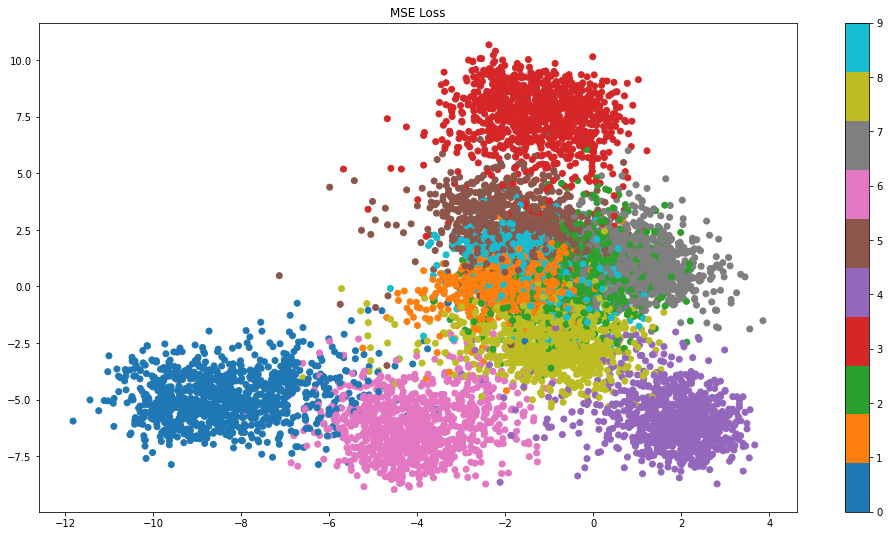

In [39]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


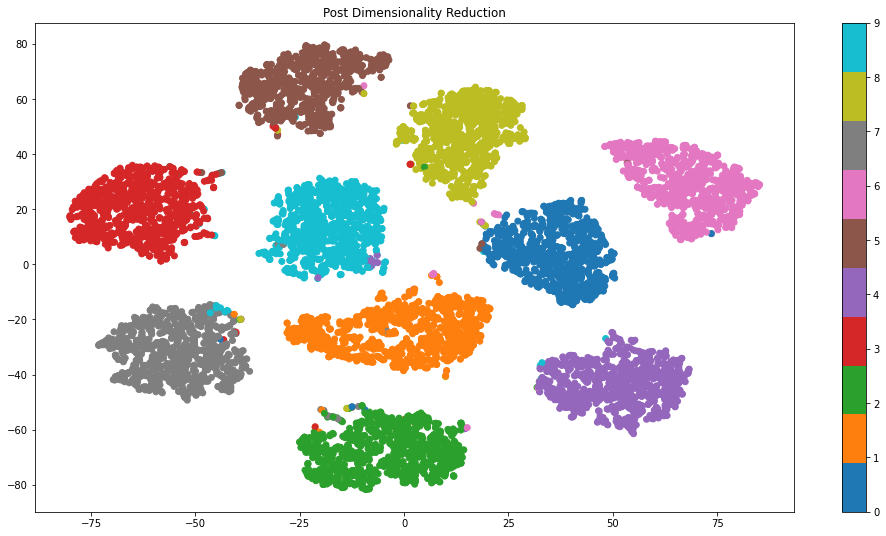

In [44]:
%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [45]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [46]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [47]:
dftsne.head()

cluster
0        7
1        2
2        1
3        0
4        4

In [48]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(dftsne)

In [49]:
centers = kmeans.cluster_centers_

In [50]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, encoded_samples.drop(['label'],axis=1), encoded_samples['label'], name="KMeans with Embedding 8", n_runs=5)

clustering done in 0.05 ± 0.04 s 
Homogeneity: 0.961 ± 0.000
Completeness: 0.961 ± 0.000
V-measure: 0.961 ± 0.000
Adjusted Rand-Index: 0.970 ± 0.000
Silhouette Coefficient: 0.623 ± 0.002


# Model 3: Autoencoder latent space embeddings 16

In [74]:
encoder = Encoder(encoded_space_dim=16,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=16)
decoder = torch.jit.script(decoder).to(device)

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [76]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [77]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [79]:
history = model_fit(encoder, decoder, train_loader, val_loader, 
                    criterion_encoder, criterion_decoder,optimizer, 
                    device,epochs, "embed16")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.129


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 6/50 	 train loss0.038


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 11/50 	 train loss0.033


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 16/50 	 train loss0.027


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 21/50 	 train loss0.026


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 26/50 	 train loss0.024


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 31/50 	 train loss0.022


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 36/50 	 train loss0.021


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 41/50 	 train loss0.021


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 46/50 	 train loss0.020


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

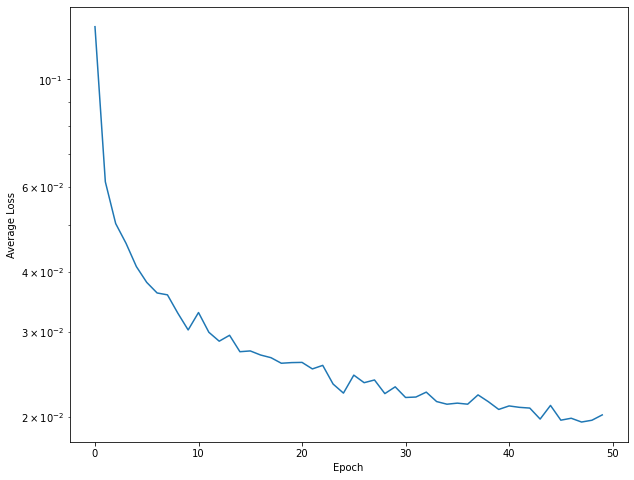

In [80]:
plot_train_loss(history)

In [81]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST'

In [82]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [83]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [84]:
encoded_samples.head()

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0         1.869000        -2.293658         3.985224        -2.395773   
1         5.003953         1.936484        -0.432304         0.941941   
2        -1.613893        -0.144815        -0.041835        -2.813709   
3        -2.178251         0.725258         1.140092         0.087460   
4        -0.284602        -0.607317         0.833245        -0.287388   

   Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0        -2.786524         1.755411        -2.596043         0.099816   
1        -0.588306         0.790621         4.852039        -3.529720   
2        -3.036839        -1.119598         6.510255        -3.833634   
3        -2.328020        -0.765491         2.430081        -5.609130   
4        -5.558521         2.251838         2.483650         1.185197   

   Enc. Variable 8  Enc. Variable 9  Enc. Variable 10  Enc. Variable 11  \
0        -5.955075        -1.139734          0.560999          2.629414   
1         2.511917        -0.892968         -3.133547          1.103794   
2        -1.306228         3.090010          3.297613         -1.998810   
3         1.591061        -2.699404         -1.421451         -0.805954   
4        -0.797336        -1.925046         -0.371539         -2.765600   

   Enc. Variable 12  Enc. Variable 13  Enc. Variable 14  Enc. Variable 15  \
0          0.820752          3.147912         -0.964841          4.536956   
1         -0.409208         -3.146937         -2.919596          5.526080   
2         -2.266197         -4.426491          3.783380          4.579722   
3          8.768510          2.695335         -3.714327          0.023656   
4          1.393342          1.684463          3.424407         -0.505990   

   label  
0      7  
1      2  
2      1  
3      0  
4      4

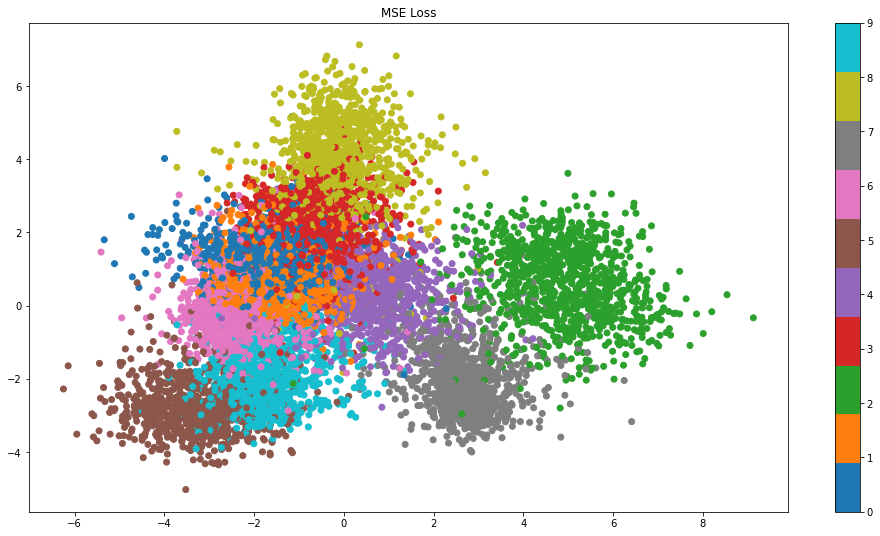

In [85]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


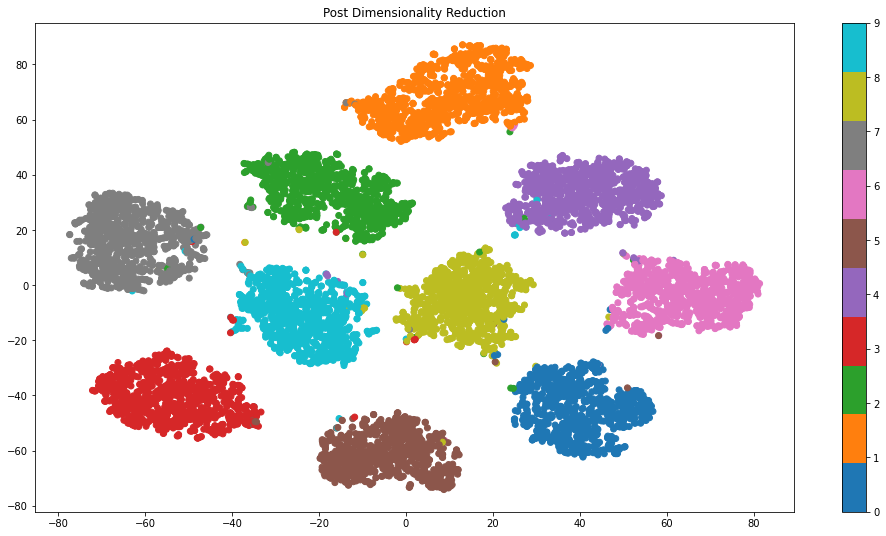

In [86]:
%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [87]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, encoded_samples.drop(['label'],axis=1), encoded_samples['label'], name="KMeans with Embedding 32", n_runs=5)

clustering done in 0.03 ± 0.00 s 
Homogeneity: 0.969 ± 0.000
Completeness: 0.969 ± 0.000
V-measure: 0.969 ± 0.000
Adjusted Rand-Index: 0.977 ± 0.000
Silhouette Coefficient: 0.616 ± 0.003


# Model 3: Autoencoder latent space embeddings 32

In [54]:
encoder = Encoder(encoded_space_dim=32,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=32)
decoder = torch.jit.script(decoder).to(device)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [56]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [57]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [59]:
history = model_fit(encoder, decoder, train_loader, val_loader, 
                    criterion_encoder, criterion_decoder,optimizer, 
                    device,epochs, "embed32")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.021


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 6/50 	 train loss0.020


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 11/50 	 train loss0.019


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 16/50 	 train loss0.019


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 21/50 	 train loss0.017


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 26/50 	 train loss0.017


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 31/50 	 train loss0.016


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 36/50 	 train loss0.016


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 41/50 	 train loss0.016


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 46/50 	 train loss0.016


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

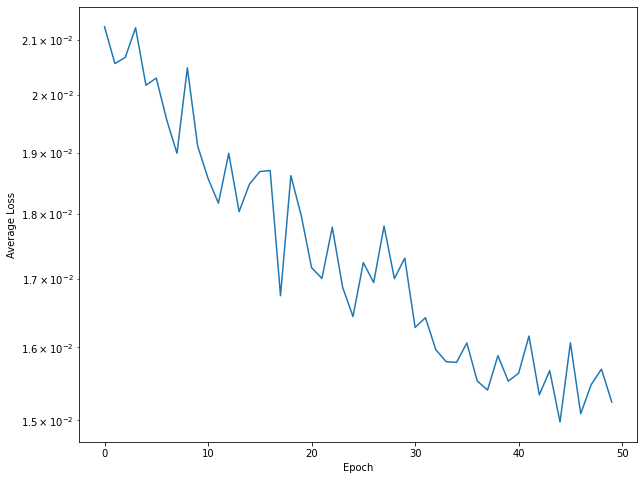

In [62]:
plot_train_loss(history)

In [63]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST'

In [64]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [65]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
encoded_samples.head()

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0         1.710657        -0.375895        -3.944535        -1.223281   
1         0.036983         0.417819         2.733254        -1.052471   
2         3.850396         0.642019         4.775529        -3.487722   
3        -1.870334        -3.155536         4.362578        -1.838856   
4         0.358613        -0.523650        -2.979408        -2.587750   

   Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0         1.827752         0.462630         1.045954         5.827826   
1        -2.267593        -3.343056        -0.735233        -2.387334   
2         1.242828         2.380655        -0.584924         1.108105   
3        -2.718412        -4.648414        -0.924899        -0.526713   
4         1.789691         1.286200         0.275685         1.161793   

   Enc. Variable 8  Enc. Variable 9  ...  Enc. Variable 23  Enc. Variable 24  \
0         3.554212        -0.843415  ...          0.382572          0.996227   
1        -2.411687         0.481417  ...         -0.274690         -1.045530   
2         2.975010         2.778996  ...         -3.312676         -1.959377   
3         1.304011         4.230264  ...          2.589264         -0.552757   
4        -1.207077         1.842078  ...          0.071251          5.938766   

   Enc. Variable 25  Enc. Variable 26  Enc. Variable 27  Enc. Variable 28  \
0         -0.105692          0.962908         -1.291284          2.285669   
1         -5.779046          2.138176         -2.083635          0.962802   
2          3.030966         -2.958919          0.429496          3.077640   
3         -2.459300          3.025074         -0.670677          0.448641   
4          3.200942         -5.849187         -2.991849         -0.934235   

   Enc. Variable 29  Enc. Variable 30  Enc. Variable 31  label  
0          3.212432          1.713480         -2.178256      7  
1          0.728610          4.960752         -0.876454      2  
2          1.941271          8.329017          1.827826      1  
3         11.097910          7.336104         -2.316358      0  
4         -0.377608          1.313787         -1.873378      4  

[5 rows x 33 columns]

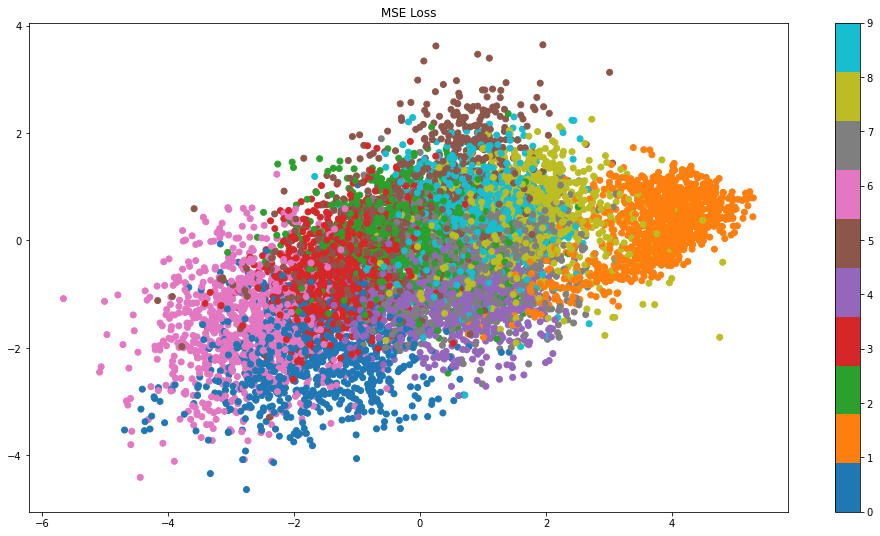

In [67]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.6 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


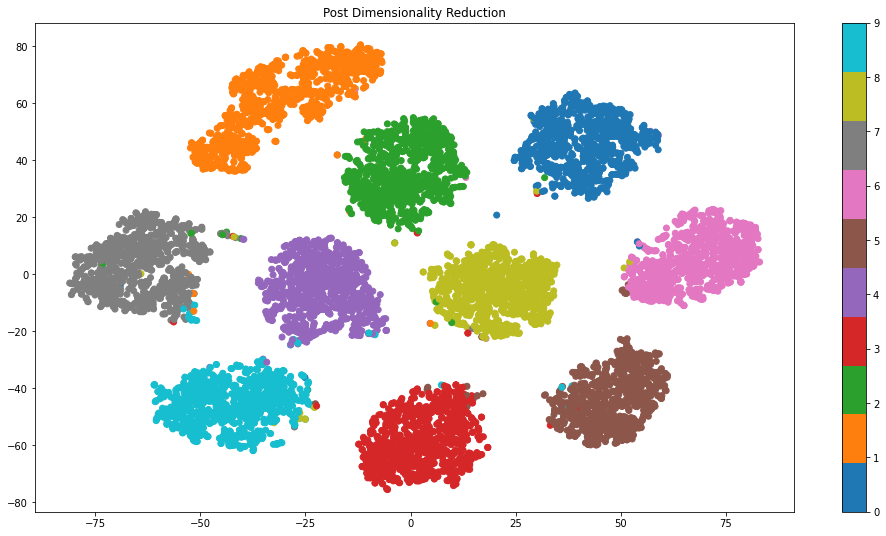

In [68]:
%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [73]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, encoded_samples.drop(['label'],axis=1), encoded_samples['label'], name="KMeans with Embedding 32", n_runs=5)

clustering done in 0.05 ± 0.00 s 
Homogeneity: 0.968 ± 0.000
Completeness: 0.968 ± 0.000
V-measure: 0.968 ± 0.000
Adjusted Rand-Index: 0.976 ± 0.000
Silhouette Coefficient: 0.576 ± 0.003


# Visualize Stats

In [69]:
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

In [70]:
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

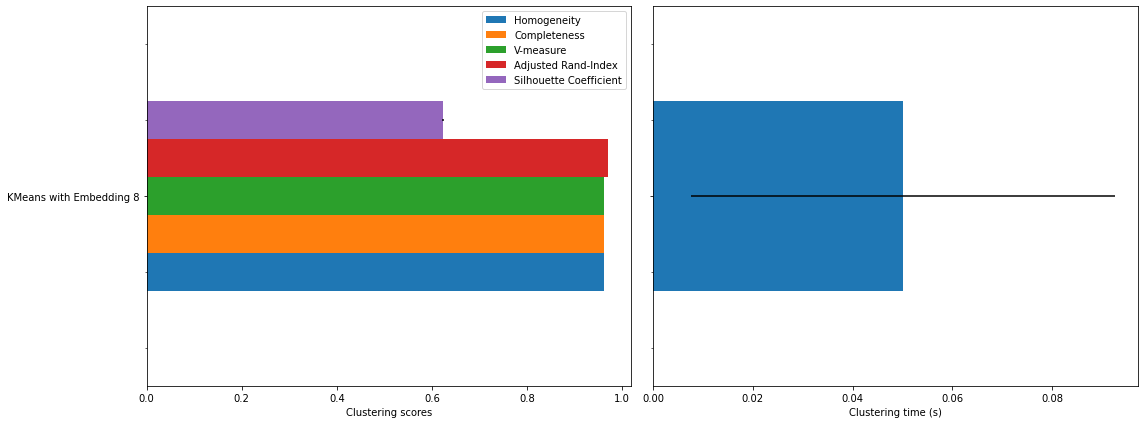

In [71]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()